In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [ ]:
# Cargar y limpiar datos
ruta = 'DATOS EVOLUTIVO.xlsx'
df = pd.read_excel(ruta, index_col= False) 

In [11]:
# Ver las primeras 5 filas
df.head(5)

,Fecha,Madrid,SM Madrid,SB anual,Poblacion madrid,Nº DE LICENCIA CONSTRUCCION,Nº DE EDIFICIOS,Nº DE VIVIENDAS
0,2008-06-01,3449,25008.085,23252,6271638,107583,93526,267322
1,2009-06-01,3325,25690.655,24164,6386932,81251,51667,130077
2,2010-06-01,3264,25868.725,24786,6458684,75488,44671,90580
3,2011-06-01,3227,25741.025,25515,6489680,70736,38881,75567
4,2012-06-01,2963,25978.675,25894,6498560,61578,28879,57314


In [12]:
# Comprobar las columnas - verlos datos que tiene
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Fecha                        15 non-null     datetime64[ns]
 1   Madrid                       15 non-null     int64         
 2   SM Madrid                    15 non-null     float64       
 3   SB  anual                    15 non-null     object        
 4   Poblacion madrid             15 non-null     int64         
 5   Nº DE LICENCIA CONSTRUCCION  15 non-null     int64         
 6   Nº DE EDIFICIOS              15 non-null     int64         
 7   Nº DE VIVIENDAS              15 non-null     int64         
dtypes: datetime64[ns](1), float64(1), int64(5), object(1)
memory usage: 1.1+ KB


#   Que hacer con los datos

- Poner todos los datos en int64
- Pasar a Datetime la fecha columna

In [6]:
df.shape

(15, 8)

c:\Users\LENOVO\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


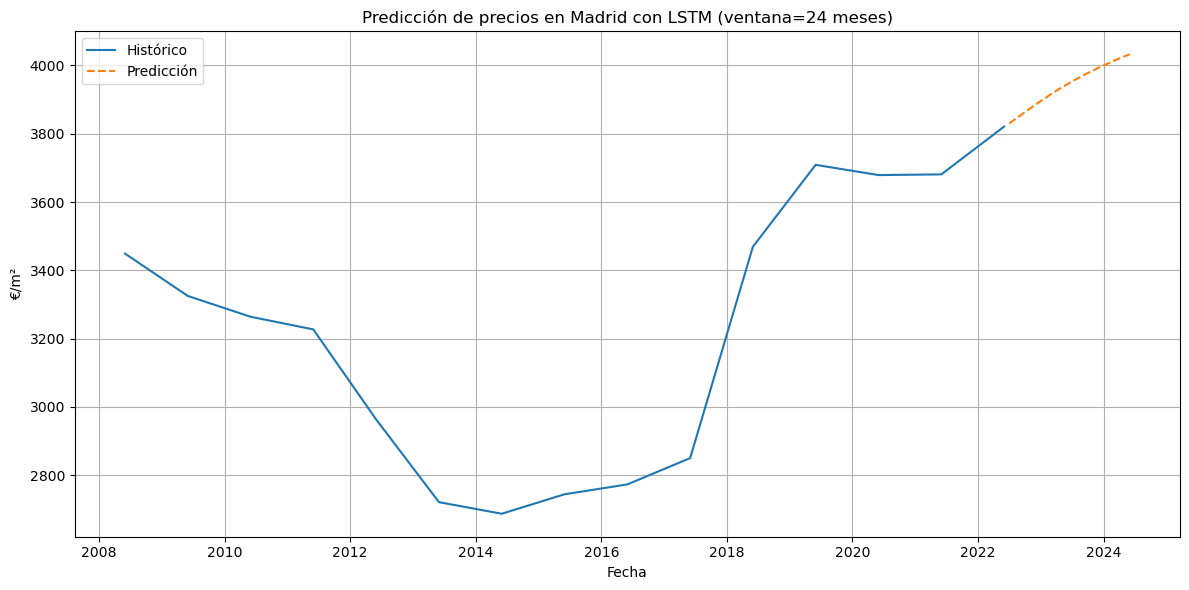

Predicciones exportadas a 'predicciones_madrid.xlsx'
2022-07: €3.830,42
2022-08: €3.841,56
2022-09: €3.852,70
2022-10: €3.863,76
2022-11: €3.874,70
2022-12: €3.885,44
2023-01: €3.895,97
2023-02: €3.906,23
2023-03: €3.916,23
2023-04: €3.925,93
2023-05: €3.935,32
2023-06: €3.944,38
2023-07: €3.953,13
2023-08: €3.961,57
2023-09: €3.969,74
2023-10: €3.977,66
2023-11: €3.985,36
2023-12: €3.992,83
2024-01: €4.000,07
2024-02: €4.007,09
2024-03: €4.013,87
2024-04: €4.020,41
2024-05: €4.026,70
2024-06: €4.032,74


In [15]:
# --- Dependencias ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# --- 1. Cargar y preparar datos ---
ruta = 'DATOS EVOLUTIVO.xlsx'  # Ajusta si corres fuera de este entorno
sheet = "Hoja1"                           # En tu archivo la hoja se llama así

# Leer
df = pd.read_excel(ruta, sheet_name=sheet)

# Normalizar nombres de columnas (quitar espacios raros/nbsp)
df.columns = [str(c).replace("\xa0", " ").strip() for c in df.columns]

# Verifica que existen las columnas esperadas
if "Fecha" not in df.columns:
    raise ValueError("No se encontró la columna 'Fecha' en el Excel.")
if "Madrid" not in df.columns:
    raise ValueError("No se encontró la columna 'Madrid' en el Excel.")

# Parsear fecha y ordenar
df["Fecha"] = pd.to_datetime(df["Fecha"], errors="coerce")
df = df.dropna(subset=["Fecha"]).sort_values("Fecha")

# Seleccionar variable objetivo (€/m²)
target_col = "Madrid"
serie = df[["Fecha", target_col]].copy()

# Re-muestrear a frecuencia mensual e interpolar (los datos originales son anuales ~junio)
serie = (serie
         .set_index("Fecha")
         .asfreq("MS")  # Monthly Start
         .interpolate(method="time"))  # interpola de forma temporal

# --- 2. Normalizar ---
scaler = MinMaxScaler()
scaled = scaler.fit_transform(serie[[target_col]].values)  # (n,1)

# --- 3. Crear secuencias para LSTM ---
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

# Elegir ventana acorde al tamaño disponible (evita 144 si no hay tantos meses)
n_obs = len(scaled)
# Ventana entre 6 y 24 meses, pero < n_obs
window_size = max(6, min(24, n_obs - 6))
X, y = create_sequences(scaled, window_size)

# Ajustar dimensiones para LSTM: (samples, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

# --- 4. Construir modelo LSTM ---
model = Sequential([
    LSTM(units=50, return_sequences=False, input_shape=(X.shape[1], 1)),
    Dense(1)
])
model.compile(optimizer="adam", loss="mean_squared_error")

# --- 5. Entrenar ---
model.fit(X, y, epochs=200, batch_size=16, verbose=0)

# --- 6. Predicción a futuro ---
last_sequence = scaled[-window_size:].copy()  # (window_size, 1)
future_preds_scaled = []

n_months = 24  # Próximos 2 años
for _ in range(n_months):
    pred_input = last_sequence.reshape((1, window_size, 1))
    pred = model.predict(pred_input, verbose=0)[0][0]
    future_preds_scaled.append(pred)
    # Desplazar ventana e incorporar la predicción
    last_sequence = np.vstack([last_sequence[1:], [[pred]]])

# Desescalar
future_preds_real = scaler.inverse_transform(
    np.array(future_preds_scaled).reshape(-1, 1)
).flatten()

# --- 7. Fechas futuras y gráfico ---
last_date = serie.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1),
                             periods=n_months, freq="MS")

plt.figure(figsize=(12, 6))
plt.plot(serie.index, serie[target_col], label="Histórico")
plt.plot(future_dates, future_preds_real, label="Predicción", linestyle="--")
plt.xlabel("Fecha")
plt.ylabel("€/m²")
plt.title(f"Predicción de precios en Madrid con LSTM (ventana={window_size} meses)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 8. Exportar resultados ---
df_predicciones = pd.DataFrame({
    "Fecha": future_dates,
    "Valor_m2_Predicho": future_preds_real
})
out_path = "predicciones_madrid.xlsx"
df_predicciones.to_excel(out_path, index=False)

print(f"Predicciones exportadas a '{out_path}'")

# (Opcional) Imprimir en formato legible
for date, val in zip(future_dates, future_preds_real):
    print(f"{date.strftime('%Y-%m')}: €{val:,.2f}".replace(",", "X").replace(".", ",").replace("X", "."))


c:\Users\LENOVO\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


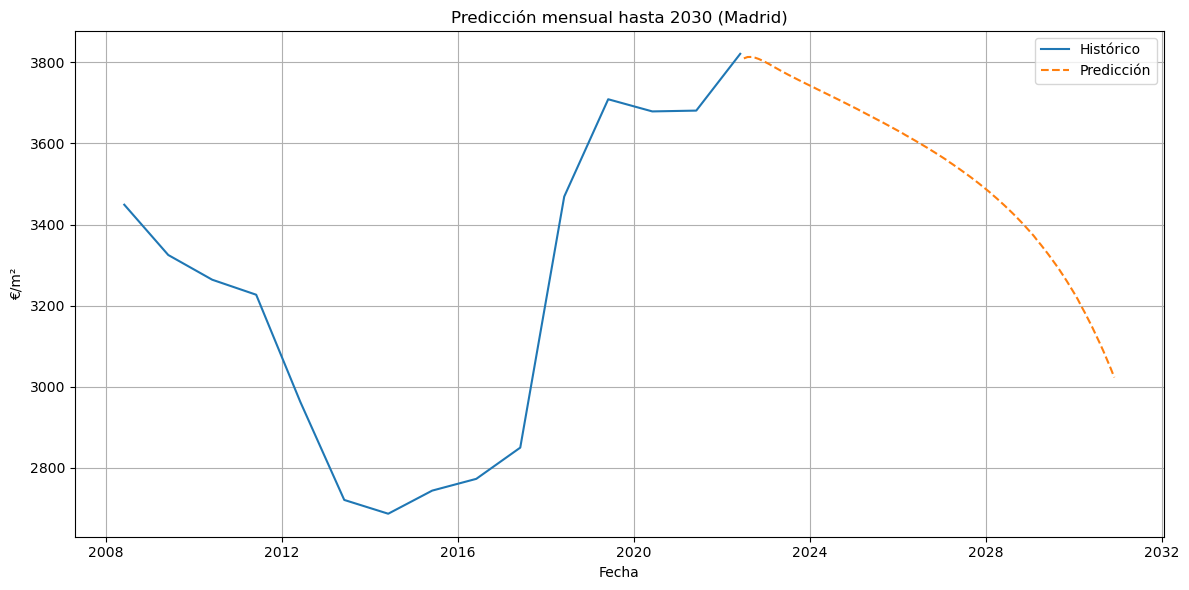

Predicciones exportadas a 'predicciones_hasta_2030.xlsx'


In [1]:
# --- Dependencias ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# --- 1) Cargar y preparar datos (ajusta ruta si no es el mismo path) ---
ruta = "DATOS EVOLUTIVO.xlsx"
sheet = "Hoja1"

df = pd.read_excel(ruta, sheet_name=sheet)
df.columns = [str(c).replace("\xa0", " ").strip() for c in df.columns]

# Usa 'Fecha' y la serie objetivo 'Madrid' (cámbiala si quieres otra)
df["Fecha"] = pd.to_datetime(df["Fecha"], errors="coerce", dayfirst=True)
df = df.dropna(subset=["Fecha"]).sort_values("Fecha")
target_col = "Madrid"

# Serie mensual e interpolación
serie = (df[["Fecha", target_col]]
         .set_index("Fecha")
         .asfreq("MS")
         .interpolate(method="time"))
serie[target_col] = serie[target_col].ffill().bfill()

# --- 2) Normalizar ---
scaler = MinMaxScaler()
scaled = scaler.fit_transform(serie[[target_col]].values)  # (n,1)

# --- 3) Secuencias ---
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

n_obs = len(scaled)
window_size = max(6, min(24, n_obs - 6))  # ventana segura
X, y = create_sequences(scaled, window_size)
X = X.reshape((X.shape[0], X.shape[1], 1))

# --- 4) Modelo LSTM ---
model = Sequential([
    LSTM(50, return_sequences=False, input_shape=(X.shape[1], 1)),
    Dense(1)
])
model.compile(optimizer="adam", loss="mean_squared_error")

# --- 5) Entrenamiento ---
model.fit(X, y, epochs=200, batch_size=16, verbose=0)

# --- 6) Horizonte hasta 2030-12 ---
last_date = serie.index[-1]
start_forecast = (last_date + pd.DateOffset(months=1)).to_period("M").to_timestamp()
end_2030 = pd.Timestamp("2030-12-01")
n_months = 0 if start_forecast > end_2030 else len(pd.period_range(start_forecast, end_2030, freq="M"))

# Predicción recursiva
last_seq = scaled[-window_size:].copy()
future_scaled = []
for _ in range(n_months):
    pred = model.predict(last_seq.reshape(1, window_size, 1), verbose=0)[0][0]
    future_scaled.append(pred)
    last_seq = np.vstack([last_seq[1:], [[pred]]])

future_vals = scaler.inverse_transform(np.array(future_scaled).reshape(-1,1)).flatten()
future_dates = pd.date_range(start=start_forecast, periods=n_months, freq="MS")

# --- 7) Gráfico ---
plt.figure(figsize=(12,6))
plt.plot(serie.index, serie[target_col], label="Histórico")
if n_months > 0:
    plt.plot(future_dates, future_vals, linestyle="--", label="Predicción")
plt.xlabel("Fecha"); plt.ylabel("€/m²")
plt.title(f"Predicción mensual hasta 2030 ({target_col})")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()

# --- 8) Exportar ---
df_predicciones = pd.DataFrame({"Fecha": future_dates, "Valor_m2_Predicho": future_vals})
df_predicciones.to_excel("predicciones_hasta_2030.xlsx", index=False)
print("Predicciones exportadas a 'predicciones_hasta_2030.xlsx'")
